In [1]:

import os, sys, math, time
import numpy as np
import numpy.linalg as la
import plotly.graph_objects as go
import plotly.express as ex
from plotly.subplots import make_subplots
import pandas as pd

import json as js
import _pickle as pickle
import bz2
import ray

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from collections import OrderedDict

from cytoolz import sliding_window, accumulate, get
import pytorch_lightning as pl
from operator import add
from tabulate import tabulate

from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler, PopulationBasedTraining
from ray.tune.integration.pytorch_lightning import TuneReportCallback, TuneReportCheckpointCallback

import ray
import ray.tune as tune


sys.path.append("../")
sys.path.append("../rig_agnostic_encoding")
sys.path.append("../rig_agnostic_encoding/models")
sys.path.append("../rig_agnostic_encoding/functions")
import func
# from MLP_withLabel import MLP_withLabel
# from MLP import MLP

In [2]:
DATA_PATH = "/home/nuoc/Documents/MEX/data"
MODEL_PATH = "/home/nuoc/Documents/MEX/models"
RESULTS_PATH = "/home/nuoc/Documents/MEX/results"


In [3]:
class MLP_withLabel(pl.LightningModule):
    def __init__(self, config:dict=None, dimensions:list=None, extra_feature_len:int=0,
                 train_set=None, val_set=None, test_set=None,
                 keep_prob:float=.2, name:str="model", load=False,
                 single_module:int=0):

        super(MLP_withLabel, self).__init__()
        self.name = name
        self.dimensions = dimensions
        self.keep_prob = keep_prob
        self.single_module = single_module
        self.extra_feature_len = extra_feature_len
        self.act = nn.ELU
        self.k = 0
        if load:
            self.build()
        else:
            self.hidden_dim = config["hidden_dim"]
            self.k = config["k"]
            self.learning_rate = config["lr"]
            self.act = config["activation"]
            self.loss_fn = config["ae_loss_fn"]
            self.batch_size = config["batch_size"]

            self.dimensions = [self.dimensions[0]-extra_feature_len, self.hidden_dim, self.k]
            self.train_set = train_set
            self.val_set = val_set
            self.test_set = test_set

            self.best_val_loss = np.inf

        self.build()
        self.encoder.apply(self.init_params)
        self.decoder.apply(self.init_params)


    def build(self):
        layer_sizes = list(sliding_window(2, self.dimensions))
        if self.single_module == -1 or self.single_module == 0:
            layers = []
            for i, size in enumerate(layer_sizes):
                layers.append(("fc"+str(i), nn.Linear(size[0], size[1])))
                if i < len(self.dimensions)-2:
                    layers.append(("act"+str(i), self.act()))
                    layers.append(("drop"+str(i+1), nn.Dropout(self.keep_prob)))
            self.encoder = nn.Sequential(OrderedDict(layers))
        else:
            self.encoder = nn.Sequential()

        if self.single_module == 0 or self.single_module == 1:
            layers = []
            layer_sizes[-1] = (layer_sizes[-1][0], layer_sizes[-1][1] + self.extra_feature_len)
            for i, size in enumerate(layer_sizes[-1::-1]):
                layers.append(("fc"+str(i), nn.Linear(size[1], size[0])))
                if i < len(self.dimensions)-2:
                    layers.append(("act"+str(i), self.act()))
                    layers.append(("drop"+str(i+1), nn.Dropout(self.keep_prob)))
            self.decoder = nn.Sequential(OrderedDict(layers))
        else:
            self.decoder = nn.Sequential()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.decode(*self.encode(x))

    def encode(self, x):
        _x, label = x[:, :-self.extra_feature_len], x[:, -self.extra_feature_len:]
        h = self.encoder(_x)
        return h, label

    def decode(self, h, label):
        hr = torch.cat((h, label), dim=1)
        return self.decoder(hr)

    def training_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_fn(prediction, y)

        self.log("ptl/train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        prediction = self(x)
        loss = self.loss_fn(prediction, y)

        self.log('ptl/val_loss', loss, prog_bar=True)
        return {"val_loss":loss}

    def test_step(self, batch, batch_idx):
        x, y = batch

        prediction = self(x)
        loss = self.loss_fn(prediction, y)

        self.log('ptl/test_loss', loss, prog_bar=True)
        return {"val_loss":loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.log("avg_val_loss", avg_loss)
        if avg_loss < self.best_val_loss:
            self.best_val_loss = avg_loss
            self.save_checkpoint(best_val_loss=self.best_val_loss.cpu().numpy())

    def save_checkpoint(self, best_val_loss:float=np.inf, checkpoint_dir=MODEL_PATH):

        model = {"k":self.k, "dimensions":self.dimensions,"keep_prob":self.keep_prob, "name":self.name,
                 "extra_feature_len" : self.extra_feature_len,
                 "encoder":self.encoder.state_dict(),
                 "decoder":self.decoder.state_dict()}

        if not os.path.exists(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        path = os.path.join(checkpoint_dir, self.name)
        if not os.path.exists(path):
            os.mkdir(path)

        filePath = os.path.join(path, str(best_val_loss)+"."+str(self.k)+".pbz2")
        with bz2.BZ2File(filePath, "w") as f:
            pickle.dump(model, f)
        return filePath

    @staticmethod
    def load_checkpoint(filePath):
        with bz2.BZ2File(filePath, "rb") as f:
            obj = pickle.load(f)

        model = MLP_withLabel(name=obj["name"], dimensions=obj["dimensions"], extra_feature_len=obj["extra_feature_len"], keep_prob=obj["keep_prob"], load=True)
        model.encoder.load_state_dict(obj["encoder"])
        model.decoder.load_state_dict(obj["decoder"])
        return model

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def setup_data(self):
        pass
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, pin_memory=True)

    @staticmethod
    def init_params(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(.01)

In [4]:
class MLP(pl.LightningModule):
    def __init__(self, config:dict=None, dimensions:list=None,
                 train_set=None, val_set=None, test_set=None,
                 keep_prob:float=.2, name:str="model", load=False,
                 single_module:int=0):

        super(MLP, self).__init__()
        self.name = name
        self.dimensions = dimensions
        self.keep_prob = keep_prob
        self.single_module = single_module
        self.act = nn.ELU
        self.k = 0
        if load:
            self.build()
        else:
            self.hidden_dim = config["hidden_dim"]
            self.k = config["k"]
            self.learning_rate = config["lr"]
            self.act = config["activation"]
            self.loss_fn = config["loss_fn"]
            self.batch_size = config["batch_size"]

            self.dimensions = dimensions + [self.hidden_dim, self.k]
            self.train_set = train_set
            self.val_set = val_set
            self.test_set = test_set

            self.best_val_loss = np.inf

            self.build()
        self.encoder.apply(self.init_params)
        self.decoder.apply(self.init_params)


    def build(self):
        layer_sizes = list(sliding_window(2, self.dimensions))
        if self.single_module == -1 or self.single_module == 0:
            layers = []
            for i, size in enumerate(layer_sizes):
                layers.append(("fc"+str(i), nn.Linear(size[0], size[1])))
                if i < len(self.dimensions)-2:
                    layers.append(("act"+str(i), self.act()))
                    layers.append(("drop"+str(i+1), nn.Dropout(self.keep_prob)))
            self.encoder = nn.Sequential(OrderedDict(layers))
        else:
            self.encoder = nn.Sequential()

        if self.single_module == 0 or self.single_module == 1:
            layers = []
            for i, size in enumerate(layer_sizes[-1::-1]):
                layers.append(("fc"+str(i), nn.Linear(size[1], size[0])))
                if i < len(self.dimensions)-2:
                    layers.append(("act"+str(i), self.act()))
                    layers.append(("drop"+str(i+1), nn.Dropout(self.keep_prob)))
            self.decoder = nn.Sequential(OrderedDict(layers))
        else:
            self.decoder = nn.Sequential()

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.decode(self.encode(x))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, h):
        return self.decoder(h)

    def training_step(self, batch, batch_idx):
        x, y = batch
        prediction = self(x)
        loss = self.loss_fn(prediction, y)

        self.log("ptl/train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        prediction = self(x)
        loss = self.loss_fn(prediction, y)

        self.log('ptl/val_loss', loss, prog_bar=True)
        return {"val_loss":loss}

    def test_step(self, batch, batch_idx):
        x, y = batch

        prediction = self(x)
        loss = self.loss_fn(prediction, y)

        self.log('ptl/test_loss', loss, prog_bar=True)
        return {"val_loss":loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.log("avg_val_loss", avg_loss)
        if avg_loss < self.best_val_loss:
            self.best_val_loss = avg_loss
            self.save_checkpoint(best_val_loss=self.best_val_loss.cpu().numpy())

    def save_checkpoint(self, best_val_loss:float=np.inf, checkpoint_dir=MODEL_PATH):

        model = {"k":self.k, "dimensions":self.dimensions,"keep_prob":self.keep_prob, "name":self.name,
                 "single_module":self.single_module,
                 "encoder":self.encoder.state_dict(),
                 "decoder":self.decoder.state_dict()}

        if not os.path.exists(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        path = os.path.join(checkpoint_dir, self.name)
        if not os.path.exists(path):
            os.mkdir(path)

        filePath = os.path.join(path, str(best_val_loss)+"."+str(self.k)+".pbz2")
        with bz2.BZ2File(filePath, "w") as f:
            pickle.dump(model, f)
        return filePath

    @staticmethod
    def load_checkpoint(filePath):
        with bz2.BZ2File(filePath, "rb") as f:
            obj = pickle.load(f)

        model = MLP(name=obj["name"], dimensions=obj["dimensions"], keep_prob=obj["keep_prob"],
                  load=True)
        model.encoder.load_state_dict(obj["encoder"])
        # model.decoder.load_state_dict(obj["decoder"])
        return model

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

    def setup_data(self):
        pass
    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, pin_memory=True)

    @staticmethod
    def init_params(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(.01)

In [5]:
class MoE(nn.Module):
    def __init__(self, config=None, dimensions=None, phase_input_dim:int=0,
                 gate_size=0, k_experts=1, keep_prob=.2,
                 name="model", load=False):
        super().__init__()

        self.phase_input_dim = phase_input_dim
        self.dimensions = dimensions
        self.act_fn = nn.ELU
        self.name = name
        self.config=config
        self.gate_size=gate_size
        self.k_experts = k_experts
        self.keep_prob = .2
        if not load:
            self.k_experts = config["k_experts"]
            self.gate_size = config["gate_size"]
            self.keep_prob = config["keep_prob"]
            self.dimensions = [self.dimensions[0], config["hidden_dim"], config["hidden_dim"], self.dimensions[-1]]

        self.layers = []

        self.build()
        self.gate = nn.Sequential(
            nn.Linear(phase_input_dim, self.gate_size),
            nn.ELU(),
            nn.Linear(self.gate_size, self.gate_size),
            nn.ELU(),
            nn.Linear(self.gate_size, self.k_experts)
        )
        self.init_params()


    def forward(self, x:torch.Tensor, phase) -> torch.Tensor:
        coefficients = F.softmax(self.gate(phase), dim=1)

        layer_out = x
        for (weight, bias, activation) in self.layers:
            if weight is None:
                layer_out = activation(layer_out, p=self.keep_prob)
            else:
                flat_weight = weight.flatten(start_dim=1, end_dim=2)
                mixed_weight = torch.matmul(coefficients, flat_weight).view(
                    coefficients.shape[0], *weight.shape[1:3]
                )

                input = layer_out.unsqueeze(1)
                mixed_bias = torch.matmul(coefficients, bias).unsqueeze(1)
                out = torch.baddbmm(mixed_bias, input, mixed_weight).squeeze(1)
                layer_out = activation(out) if activation is not None else out

        return layer_out

    def build(self):
        layers = []
        for i, size in enumerate(zip(self.dimensions[0:], self.dimensions[1:])):
            if i < len(self.dimensions) - 2:
                layers.append(
                    (
                        nn.Parameter(torch.empty(self.k_experts, size[0], size[1])),
                        nn.Parameter(torch.empty(self.k_experts, size[1])),
                        self.act_fn()
                    )
                )
            else:
                layers.append(
                    (
                        nn.Parameter(torch.empty(self.k_experts, size[0], size[1])),
                        nn.Parameter(torch.empty(self.k_experts, size[1])),
                        None
                    )
                )

            if self.keep_prob > 0:
                layers.append((None, None, F.dropout))

        self.layers = layers

    def init_params(self):
        for i, (w, b, _) in enumerate(self.layers):
            if w is None:
                continue

            i = str(i)
            torch.nn.init.kaiming_uniform_(w)
            b.data.fill_(0.01)
            self.register_parameter("w" + i, w)
            self.register_parameter("b" + i, b)

    def save_checkpoint(self, best_val_loss:float=np.inf, checkpoint_dir=MODEL_PATH):

        model = {"dimensions":self.dimensions,
                 "name":self.name,
                 "gate":self.gate.state_dict(), "phase_input_dim":self.phase_input_dim,
                 "generationNetwork":self.state_dict(),
                 "gate_size":self.gate_size,
                 "k_experts":self.k_experts,
                 }

        if not os.path.exists(checkpoint_dir):
            os.mkdir(checkpoint_dir)
        path = os.path.join(checkpoint_dir, self.name)
        if not os.path.exists(path):
            os.mkdir(path)

        filePath = os.path.join(path, str(best_val_loss)+".pbz2")
        with bz2.BZ2File(filePath, "w") as f:
            pickle.dump(model, f)
        return filePath

    @staticmethod
    def load_checkpoint(filePath):
        with bz2.BZ2File(filePath, "rb") as f:
            obj = pickle.load(f)

        model = MoE(name=obj["name"], dimensions=obj["dimensions"], gate_size=obj["gate_size"],k_experts=obj["k_experts"],
                    phase_input_dim=obj["phase_input_dim"], load=True)
        model.gate.load_state_dict(obj["gate"])
        model.load_state_dict(obj["generationNetwork"])
        return model

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.99)
        return optimizer


In [101]:
class MotionGenerationModel(pl.LightningModule):
    def __init__(self, config:dict=None, pose_autoencoder=None, cost_input_dimension=None, phase_dim=0,
                 input_slicers:list=None, output_slicers:list=None, train_set=None, val_set=None, name="model", load=False):
        super().__init__()

        if not load:
            self.pose_autoencoder = pose_autoencoder # start with 3
            cost_hidden_dim = config["cost_hidden_dim"]
            cost_output_dim = config["cost_output_dim"]
            self.cost_encoder = MLP(dimensions=[cost_input_dimension, cost_hidden_dim, cost_hidden_dim, cost_output_dim],
                                    name="CostEncoder", load=True, single_module=-1)


            phase_dim = input_slicers[0]
            moe_input_dim = pose_autoencoder.dimensions[-1] + cost_output_dim
            moe_output_dim = pose_autoencoder.dimensions[-1] +  phase_dim*2 + cost_input_dimension
            self.generationModel =  MoE(config=config, dimensions=[moe_input_dim, moe_output_dim], phase_input_dim=phase_dim,
                                        name="MixtureOfExperts")

            self.in_slices = [0] + list(accumulate(add, input_slicers))
            self.out_slices = [0] + list(accumulate(add, output_slicers))
            self.phase_dim = phase_dim

            self.config=config
            self.batch_size = config["batch_size"]
            self.learning_rate = config["lr"]
            self.loss_fn = config["loss_fn"]
            self.window_size = config["window_size"]
            self.autoregress_chunk_size = config["autoregress_chunk_size"]
            self.autoregress_prob = config["autoregress_prob"]
            self.autoregress_inc = config["autoregress_inc"]
            self.best_val_loss = np.inf
            self.phase_smooth_factor = 0.9

        self.train_set = train_set
        self.val_set = val_set
        self.name = name
        self.epochs = 0



    def forward(self, x):
        x_tensors = [x[:, d0:d1] for d0, d1 in zip(self.in_slices[:-1], self.in_slices[1:])]
        pose_h, pose_label = self.pose_autoencoder.encode(x_tensors[1])
        phase = x_tensors[0][:, :self.phase_dim]
        targets = x_tensors[0][:, self.phase_dim:]
        embedding = torch.cat([pose_h, self.cost_encoder(x_tensors[2])], dim=1)
        # embedding = torch.cat([pose_h, x_tensors[2]], dim=1)
        out = self.generationModel(embedding, x_tensors[0])
        out_tensors = [out[:, d0:d1] for d0, d1 in zip(self.out_slices[:-1], self.out_slices[1:])] # phase, phase_update, pose

        phase = self.update_phase(phase, out_tensors[0], out_tensors[1]) # phase_0, phase_1, phase_update
        new_pose = self.pose_autoencoder.decode(out_tensors[2], pose_label)
        return torch.cat([phase, targets, new_pose, pose_label, out_tensors[-1]],dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch

        # x_chunks = torch.split(x, self.autoregress_chunk_size, dim=1)
        # y_chunks = torch.split(y, self.autoregress_chunk_size, dim=1)
        # if len(x_chunks) == 1:
        #     x_chunks = x_chunks[0]
        #     y_chunks = y_chunks[0]
        # else:
        #     x_chunks = torch.cat(x_chunks[:-1], dim=0)
        #     y_chunks = torch.cat(y_chunks[:-1], dim=0)
        #
        # if self.autoregress_chunk_size == 1:
        #     out = self(x_chunks.view((-1, x_chunks.size()[-1])))
        #     loss = self.loss_fn(out, y_chunks.view((-1, y_chunks.size()[-1])))
        # else:
        #     loss = 0
        #     x_c = x_chunks[:, 0, :]
        #     outputs = []
        #     for i in range(y_chunks.size()[1]):
        #         out = self(x_c)
        #         # loss += self.loss_fn(out, y_chunks[:, i, :])
        #         outputs.append(out.unsqueeze(dim=1))
        #         x_c = out
        #     loss = self.loss_fn(torch.cat(outputs, dim=1), y_chunks)

        n = x.size()[1]
        loss = 0
        x_c = x[:,0,:]
        if self.autoregress_prob < 1:
            autoregress_bools = torch.randn(n) < self.autoregress_prob
            for i in range(1, n):
                y_c = y[:,i-1,:]
                out = self(x_c)
                loss += self.loss_fn(out, y_c)
                if autoregress_bools[i]:
                    x_c = out
                else:
                    x_c = x[:,i,:]

            loss /= float(n)
        else:
            for i in range(1, n):
                y_c = y[:,i-1,:]
                out = self(x_c)
                loss += self.loss_fn(out, y_c)
                x_c = x[:,i,:]

            loss /= float(n)
        #

        self.log("ptl/train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        # x_chunks = torch.split(x, self.autoregress_chunk_size, dim=1)
        # y_chunks = torch.split(y, self.autoregress_chunk_size, dim=1)
        # if len(x_chunks) == 1:
        #     x_chunks = x_chunks[0]
        #     y_chunks = y_chunks[0]
        # else:
        #     x_chunks = torch.cat(x_chunks[:-1], dim=0)
        #     y_chunks = torch.cat(y_chunks[:-1], dim=0)
        #
        # if self.autoregress_chunk_size == 1:
        #     out = self(x_chunks.view((-1, x_chunks.size()[-1])))
        #     loss = self.loss_fn(out, y_chunks.view((-1, y_chunks.size()[-1])))
        # else:
        #     loss = 0
        #     x_c = x_chunks[:, 0, :]
        #     outputs = []
        #     for i in range(y_chunks.size()[1]):
        #         out = self(x_c)
        #         # loss += self.loss_fn(out, y_chunks[:, i, :])
        #         outputs.append(out.unsqueeze(dim=1))
        #         x_c = out
        #     loss = self.loss_fn(torch.cat(outputs, dim=1), y_chunks)

            # loss /= float(self.autoregress_chunk_size)

        n = x.size()[1]
        loss = 0
        x_c = x[:,0,:]
        if self.autoregress_prob < 1:
            autoregress_bools = torch.randn(n) < self.autoregress_prob
            for i in range(1, n):
                y_c = y[:,i-1,:]
                out = self(x_c)
                loss += self.loss_fn(out, y_c)
                if autoregress_bools[i]:
                    x_c = out
                else:
                    x_c = x[:,i,:]

            loss /= float(n)
        else:
            for i in range(1, n):
                y_c = y[:,i-1,:]
                out = self(x_c)
                loss += self.loss_fn(out, y_c)
                x_c = x[:,i,:]

            loss /= float(n)
        #

        self.log("ptl/val_loss", loss, prog_bar=True)
        return {"val_loss":loss}

    def validation_epoch_end(self, outputs):
        if self.epochs > 0 and self.epochs % 10==0:
            self.autoregress_prob = min(1, self.autoregress_prob+self.autoregress_inc)
            self.autoregress_chunk_size = min(120, self.autoregress_chunk_size+self.autoregress_inc)
        elif self.epochs > 0 and self.epochs % 50==0:
            self.scheduler.step()
        self.epochs += 1


        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.log("avg_val_loss", avg_loss)
        if avg_loss < self.best_val_loss:
            self.best_val_loss = avg_loss
            self.save_checkpoint()

    def save_checkpoint(self, checkpoint_dir=MODEL_PATH):
        path = os.path.join(checkpoint_dir, self.name)
        loss = self.best_val_loss.cpu().numpy()

        pose_autoencoder_path = self.pose_autoencoder.save_checkpoint(best_val_loss=loss, checkpoint_dir=path)
        cost_encoder_path = self.cost_encoder.save_checkpoint(best_val_loss=loss, checkpoint_dir=path)
        generationModel_path = self.generationModel.save_checkpoint(best_val_loss=loss, checkpoint_dir=path)

        model = {"name":self.name,
                 "pose_autoencoder_path":pose_autoencoder_path,
                 "cost_encoder_path": cost_encoder_path,
                 "motionGenerationModelPath":generationModel_path,
                 "in_slices":self.in_slices,
                 "out_slices":self.out_slices,
                 }

        if not os.path.exists(path):
            os.mkdir(path)
        with bz2.BZ2File(os.path.join(path,
                                      str(loss)+".pbz2"), "w") as f:
            pickle.dump(model, f)

    @staticmethod
    def load_checkpoint(filename, pose_ae_model, cost_encoder_model, generation_model):
        with bz2.BZ2File(filename, "rb") as f:
            obj = pickle.load(f)

        pose_autoencoder = pose_ae_model.load_checkpoint(obj["pose_autoencoder_path"])
        cost_encoder = cost_encoder_model.load_checkpoint(obj["cost_encoder_path"])
        generationModel = generation_model.load_checkpoint(obj["motionGenerationModelPath"])
        model = MotionGenerationModel(name=obj["name"])
        model.pose_autoencoder = pose_autoencoder
        model.cost_encoder = cost_encoder
        model.generationModel = generationModel
        model.in_slices = obj["in_slices"]
        model.out_slices = obj["out_slices"]

        return model

    def update_phase(self, p1, p2, p_delta):
        return self.phase_smooth_factor * p2 + (1-self.phase_smooth_factor)*(p1+p_delta)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=32, gamma=0.1)
        self.scheduler = scheduler
        return optimizer

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, pin_memory=True)






In [32]:
data_path = [
             "/home/nuoc/Documents/MEX/data/TWO_R2-default-Two.pbz2",
            "/home/nuoc/Documents/MEX/data/ONE_R2-default-One.pbz2",
             "/home/nuoc/Documents/MEX/data/ONE_R2-default-One-large.pbz2",
             "/home/nuoc/Documents/MEX/data/ONE_R2-default-One-small.pbz2",
             "/home/nuoc/Documents/MEX/data/TWO_R2-default-Two-small.pbz2",
             "/home/nuoc/Documents/MEX/data/TWO_R2-default-Two-large.pbz2",
             "/home/nuoc/Documents/MEX/data/TWO_ROT_R2-default-Two.pbz2",
             "/home/nuoc/Documents/MEX/data/TWO_ROT_R2-default-Two-large.pbz2",
             "/home/nuoc/Documents/MEX/data/TWO_ROT_R2-default-Two-small.pbz2",
             ]



pose_features = ["pos", "rotMat", "velocity", "isLeft", "chainPos", "geoDistanceNormalised"]
cost_features = ["tPos", "tRot"]
phase_features = ["phase_vec", "targetPosition", "targetRotation"]




def load(file_path):
    with bz2.BZ2File(file_path, "rb") as f:
        obj = pickle.load(f)
        return obj

data = [load(path) for path in data_path]

In [33]:
window_size = 6
frame_window = 30
sampling_step = frame_window / window_size

data_tensors = []

data_dims = []
feature_list = []

first_row = True
first_time = True
key_joints = []

a = []
b = []
for Data in data:
    for clip in Data:
        d = pickle.loads(clip)
        sequence = []
        n_frames = len(d["frames"])
        if first_time:
            key_joints = [i for i in range(len(d["frames"][0])) if d["frames"][0][i]["key"]]
            first_time = False
        for f, frame in enumerate(d["frames"]):
            row_vec = []
            f_idx = np.arange(f-frame_window, f+frame_window, sampling_step, dtype=int)
            f_idx[f_idx < 0] = 0
            f_idx[f_idx >= n_frames] = n_frames-1
            f_idx = f_idx.tolist()
            for feature in phase_features:
                if feature == "phase_vec":
                    sin = np.asarray([d["frames"][idx][jj]["phase_vec"] for jj in key_joints for idx in f_idx])
                    vel = np.concatenate([d["frames"][idx][jj]["velocity"] for jj in key_joints for idx in f_idx])
                    vel = np.reshape(vel, (3,-1))
                    vel = np.sqrt(np.sum(vel**2, axis=0))
                    cos = np.cos(np.arcsin(np.asarray([d["frames"][idx][jj]["sin_normalised_contact"] for jj in key_joints for idx in f_idx])))
                    cos = cos * vel
                    row_vec.append(np.concatenate([np.asarray([sin[i], cos[i]]) for i in range(len(sin))]))
                elif feature == "targetRotation":
                    row_vec.append(np.concatenate([frame[jj][feature].ravel() for jj in key_joints]))
                elif feature == "contact":
                    row_vec.append(np.asarray([d["frames"][idx][jj]["contact"] for jj in key_joints for idx in f_idx]))
                else:
                    row_vec.append(np.concatenate([frame[jj][feature] for jj in key_joints]))

                if first_row:
                    data_dims.append(row_vec[-1].shape)
                    feature_list.append(feature)

            for feature in pose_features:
                if feature=="rotMat":
                    row_vec.append(np.concatenate([jo["rotMat"].ravel() for jo in frame]))
                elif feature == "isLeft" or feature == "chainPos" or feature == "geoDistanceNormalised":
                    row_vec.append(np.concatenate([[jo[feature]] for jo in frame]))
                else:
                    row_vec.append(np.concatenate([jo[feature] for jo in frame]))

                if first_row:
                    data_dims.append(row_vec[-1].shape)
                    feature_list.append(feature)
            for feature in cost_features:
                if feature == "posCost" or feature == "rotCost":
                    row_vec.append(np.concatenate([d["frames"][idx][jj][feature] for jj in key_joints for idx in f_idx]))
                elif feature == "tPos" or feature == "tRot":
                    feature = "pos" if feature == "tPos" else "rotMat"
                    row_vec.append(np.concatenate([d["frames"][idx][jj][feature].ravel() for jj in key_joints for idx in f_idx]))
                else:
                    row_vec.append(np.concatenate([frame[jj][feature] for jj in key_joints]))

                if first_row:
                    data_dims.append(row_vec[-1].shape)
                    feature_list.append(feature)
            if first_row: first_row = False
            sequence.append(np.concatenate(row_vec))
        data_tensors.append(np.vstack(sequence))

In [34]:
def loss_fn(x, y):
    return nn.functional.mse_loss(x,y)
def normalise(x):
    std = torch.std(x, dim=0)
    std[std==0] = 1
    return (x-torch.mean(x, dim=0)) / std

In [35]:
extra_feature_len = 21 * 3
n_phase_features = len(phase_features)
n_pose_features = len(pose_features)
phase_dim = np.sum(data_dims[0:n_phase_features])
pp_dim = data_dims[0]
pose_dim = np.sum(data_dims[n_phase_features:n_phase_features+n_pose_features])
cost_dim = np.sum(data_dims[n_phase_features+n_pose_features:])

table = [feature_list, data_dims]
print(tabulate(table))
print("phase dim: ",phase_dim)
print("pose dim: ", pose_dim)
print("cost dim: ", cost_dim)

---------  --------------  --------------  -----  ------  --------  ------  --------  ---------------------  -----  ------
phase_vec  targetPosition  targetRotation  pos    rotMat  velocity  isLeft  chainPos  geoDistanceNormalised  pos    rotMat
(48,)      (6,)            (18,)           (63,)  (189,)  (63,)     (21,)   (21,)     (21,)                  (72,)  (216,)
---------  --------------  --------------  -----  ------  --------  ------  --------  ---------------------  -----  ------
phase dim:  72
pose dim:  378
cost dim:  288


In [36]:
x_tensors = torch.stack([normalise(torch.from_numpy(clip[:-1])).float() for clip in data_tensors])
y_tensors = torch.stack([torch.from_numpy(clip[1:]).float() for clip in data_tensors])


In [37]:
print(len(x_tensors), x_tensors[0].shape)
print(len(y_tensors), y_tensors[0].shape)


576 torch.Size([119, 738])
576 torch.Size([119, 738])


In [39]:
dataset = TensorDataset(x_tensors, y_tensors)
N = len(x_tensors)

train_ratio = int(.7*N)
val_ratio = int((N-train_ratio) / 2.0)
test_ratio = N - train_ratio - val_ratio
train_set, val_set, test_set = random_split(dataset, [train_ratio, val_ratio, test_ratio], generator=torch.Generator().manual_seed(2021))
print(len(train_set), len(val_set), len(test_set))

403 86 87


In [63]:
data_1 = {"data_sets":[train_set, val_set, test_set], "desc":"phase+pose+cost+trajectory_autoregress", "dims":[phase_dim, pp_dim, pose_dim, cost_dim]}
with bz2.BZ2File("data_sets_4_MoE_autoregressive.pbz2", "w") as f:
    pickle.dump(data_1, f)

In [104]:
input_dim = phase_dim + pose_dim + cost_dim
# output_dim = phase_dim + pose_dim-extra_feature_len
output_dim = input_dim
print(input_dim)
print(output_dim)

# config = {
#     "k_experts":tune.choice([1, 2, 4, 8, 10]),
#     "gate_size":tune.choice([16, 32, 64, 128]),
#     "keep_prob":tune.choice([.2, .25, .3]),
#     "hidden_dim":tune.choice([16, 32, 64, 128, 256, 512]),
#     "cost_hidden_dim" : tune.choice([16, 32, 64, 128]),
#     "cost_output_dim" : tune.choice([16,32,64,128]),
#     "batch_size":tune.choice([1]),
#     "lr":tune.loguniform(1e-5, 1e-7),
#     "loss_fn":tune.choice([loss_fn]),
#     "window_size":tune.choice([1]),
#     "autoregress_prob" : tune.choice([.2]),
#     "autoregress_inc" : tune.choice([2, 4]),
#     "autoregress_chunk_size": tune.choice([1, 2])
# }

config = {
    "k_experts": 4,
    "gate_size": 32,
    "keep_prob": .2,
    "hidden_dim": 256,
    "cost_hidden_dim" : 64,
    "cost_output_dim" : 64,
    "batch_size": 32,
    "lr": 1e-4,
    "loss_fn": loss_fn,
    "window_size":1,
    "autoregress_prob" :0,
    "autoregress_inc" :.1,
    "autoregress_chunk_size": 120
}






model_name = "Test_6_phase+pose+cost+trajectory_autoregress_chunk"
epochs = 200

738
738


In [102]:
pose_autoencoder = MLP_withLabel.load_checkpoint("/home/nuoc/Documents/MEX/models/MLP4_withLabel_best/M3/0.00324857.512.pbz2")
pose_encoder_out_dim = pose_autoencoder.dimensions[-1]
input_slices=[phase_dim, pose_dim, cost_dim]
output_slices=[phase_dim, phase_dim, pose_encoder_out_dim, cost_dim]

In [103]:
model = MotionGenerationModel(config=config, pose_autoencoder=pose_autoencoder, cost_input_dimension=cost_dim,
                          input_slicers=input_slices, output_slicers=output_slices,phase_dim=pp_dim,
                          train_set=train_set, val_set=val_set, name=model_name)

# optimizer = model.configure_optimizers()


GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/home/nuoc/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name             | Type          | Params
---------------------------------------------------
0 | pose_autoencoder | MLP_withLabel | 440 K 
1 | cost_encoder     | MLP           | 41.4 K
2 | generationModel  | MoE           | 2.1 M 
---------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.158    Total estimated model params size (MB)
/home/nuoc/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cp

{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

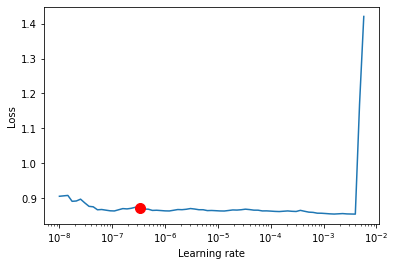

In [72]:
trainer = pl.Trainer()
# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model)

# Results can be found in
print(lr_finder.results)

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()

# update hparams of the model
model.hparams.lr = new_lr
model.learning_rate = new_lr

In [74]:
print(new_lr)

3.311311214825911e-07
3.311311214825911e-07


In [105]:
# prob
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor="avg_val_loss", save_top_k=3)
earlystopping = EarlyStopping(monitor="avg_val_loss", patience=10)
logger=TensorBoardLogger(save_dir="logs/", name=model_name, version="0.0")

trainer = pl.Trainer(
    default_root_dir="/home/nuoc/Documents/MEX/src/motion_generation/checkpoints",
    gpus=1, precision=16,
    callbacks=[checkpoint_callback,earlystopping],
    logger=logger,
    min_epochs=50,
    max_epochs=epochs,
    stochastic_weight_avg=True
)

train_loader = DataLoader(train_set, batch_size=config["batch_size"], pin_memory=True, num_workers=6)
val_loader = DataLoader(val_set, batch_size=config["batch_size"], pin_memory=True, num_workers=6)

trainer.fit(model,train_loader, val_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type          | Params
---------------------------------------------------
0 | pose_autoencoder | MLP_withLabel | 440 K 
1 | cost_encoder     | MLP           | 26.8 K
2 | generationModel  | MoE           | 1.8 M 
---------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.183     Total estimated model params size (MB)
/home/nuoc/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [100]:
#chunk

from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor="avg_val_loss", save_top_k=3)
earlystopping = EarlyStopping(monitor="avg_val_loss", patience=10)
logger=TensorBoardLogger(save_dir="logs/", name=model_name, version="0.0")

trainer = pl.Trainer(
    default_root_dir="/home/nuoc/Documents/MEX/src/motion_generation/checkpoints",
    gpus=1, precision=16,
    callbacks=[checkpoint_callback,earlystopping],
    logger=logger,
    min_epochs=50,
    max_epochs=epochs,
    stochastic_weight_avg=True
)

train_loader = DataLoader(train_set, batch_size=config["batch_size"], pin_memory=True, num_workers=6)
val_loader = DataLoader(val_set, batch_size=config["batch_size"], pin_memory=True, num_workers=6)

trainer.fit(model,train_loader, val_loader)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type          | Params
---------------------------------------------------
0 | pose_autoencoder | MLP_withLabel | 440 K 
1 | cost_encoder     | MLP           | 26.8 K
2 | generationModel  | MoE           | 1.8 M 
---------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.183     Total estimated model params size (MB)
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (50) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minim

1

In [36]:
with bz2.BZ2File("data_sets_1_MoE.pbz2", "rb") as f:
        obj = pickle.load(f)

train_set = obj["data_sets"][0]
val_set = obj["data_sets"][1]
# train_set = obj["data_sets"][0]
phase_dim = obj["dims"][0]
pose_dim = obj["dims"][1]
cost_dim = obj["dims"][2]
extra_feature_len = 21 * 3

input_dim = phase_dim + pose_dim + cost_dim
output_dim = phase_dim + pose_dim-extra_feature_len
print(input_dim)
print(output_dim)

420
343
